In [21]:
import numpy as np
import random

import cv2
from matplotlib import pyplot as plt

import tensorflow as tf

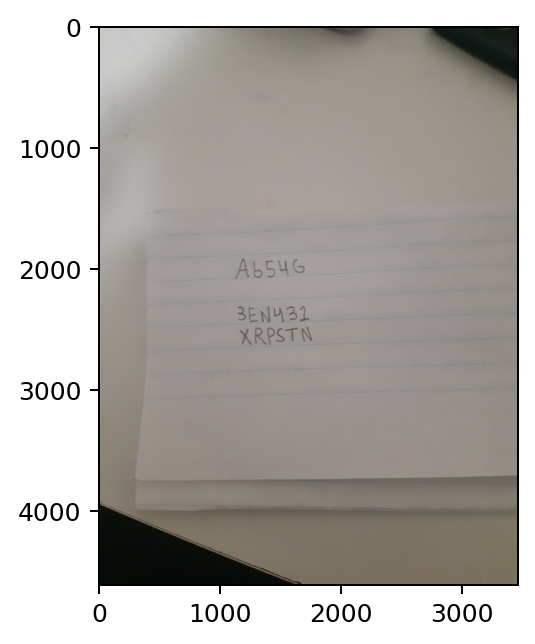

In [22]:
#read image test.jpg
imgPath = "test.jpg"
img = cv2.imread(imgPath)
plt.figure(figsize=(3, 6), dpi=180)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [23]:
def mouse_crop(event, x, y, flags, param): #mouse event used to crop image file
    global x_start, y_start, x_end, y_end, cropping
    #if the left mouse button is pressed
    if event == cv2.EVENT_LBUTTONDOWN:
        if (cropping == False): #start cropping and recording
            x_start, y_start, x_end, y_end = x, y, x, y
            cropping = True
    #if mouse is moving
    elif event == cv2.EVENT_MOUSEMOVE:
        if cropping == True: #continue to record if cropping
            x_end, y_end = x, y
    #if left mouse button is unheld
    elif event == cv2.EVENT_LBUTTONUP:
        if abs(x_start-x)<5 or abs(y_start-y)<5:#if leftmouse button click crop until next mouse press
            cropping = True
        else:#if leftmouse button held crop until mouse button released (cropping ended)
            cropping = False
            x_end, y_end = x, y
            refPoint = [(x_start, y_start), (x_end, y_end)]
            if len(refPoint) == 2:
                roi = img[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
                cv2.namedWindow("Cropped")
                cv2.setMouseCallback("Cropped", mouse_crop)
                cv2.imshow("Cropped", roi)
    elif event == cv2.EVENT_RBUTTONDOWN:#if rightmouse button pressed redo crop
        cv2.destroyWindow("Cropped")
cropping = False

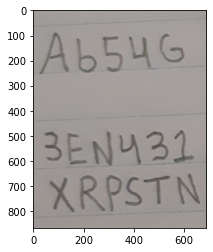

In [24]:

cv2.namedWindow("image",cv2.WND_PROP_ASPECT_RATIO)
cv2.setMouseCallback("image", mouse_crop)
cv2.setWindowProperty("image",cv2.WND_PROP_ASPECT_RATIO,cv2.WINDOW_KEEPRATIO)

while True:#show image to user to crop until any key is pressed
    i = img.copy()
    if not cropping:
        cv2.imshow("image", img)
    else:#when cropping show image with updating crop border
        cv2.rectangle(i, (x_start, y_start), (x_end, y_end), (255, 255, 255), 5)
        cv2.imshow("image", i)
    if cv2.waitKey(33)!=-1:
        break
#save and show cropped image
cv2.destroyAllWindows()
cropped = img[y_start:y_end,x_start:x_end]
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

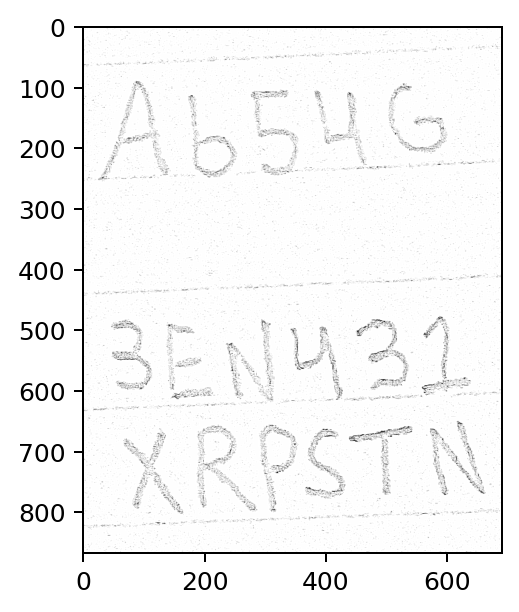

In [25]:
#filter and sharpen image
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

gray = cv2.cvtColor(cropped,cv2.COLOR_BGR2GRAY)
smooth = cv2.GaussianBlur(gray, (33,33), 0)
division = cv2.divide(gray, smooth, scale=255)

sharp = 255-cv2.filter2D(src=division*255, ddepth=-1, kernel=kernel)
sharp = sharp.clip(0,255).astype(np.uint8)

plt.figure(figsize=(3, 6), dpi=180)
plt.imshow(sharp, cmap='gray')

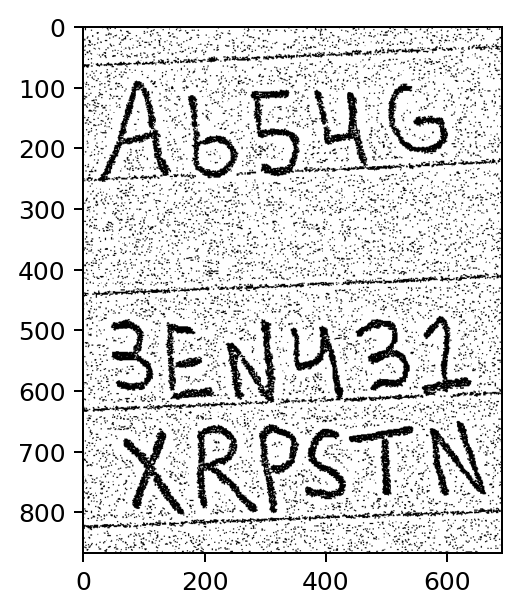

In [26]:
#convert image to binary scale
blur = cv2.blur(src=sharp, ksize=(2,2))
(_, binary) = cv2.threshold(blur, int(np.average(blur)), 255, cv2.THRESH_BINARY)

plt.figure(figsize=(3, 6), dpi=180)
plt.imshow(binary, cmap='gray')

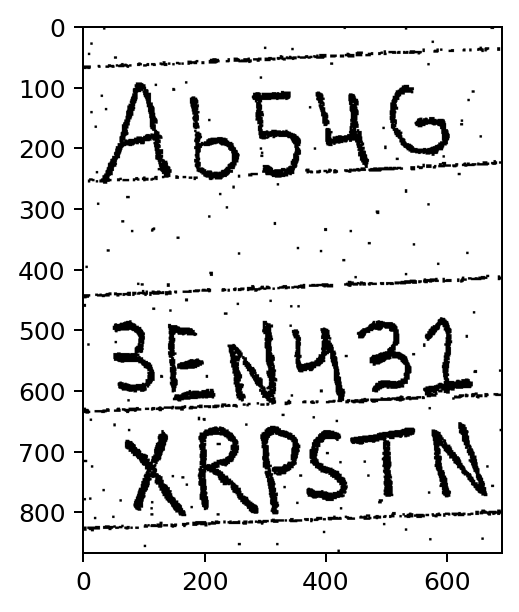

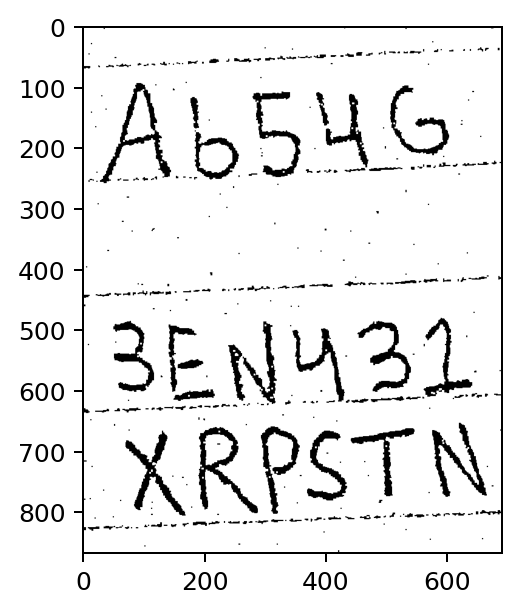

In [43]:
#erode and dilute image to remove artifacts
erosion = cv2.erode(binary, np.ones((2,2)), iterations=1)
dilation = cv2.dilate(erosion, np.ones((2,2)), iterations=3)
erosion = cv2.erode(dilation, np.ones((4,4)), iterations=1)
dilation = cv2.dilate(erosion, np.ones((3,3)), iterations=1)

plt.figure(figsize=(3, 6), dpi=180)
plt.imshow(erosion, cmap='gray')
plt.figure(figsize=(3, 6), dpi=180)
plt.imshow(dilation, cmap='gray')

In [44]:
class Character(): #Character class that stores all character info needed
    def __init__(self, image, position, size): #initialize with img, pos and size
        self.image = image
        self.pos = position
        self.size = size
        self.char = None
        
    def setIMG(self, image): #change image
        self.image = image
        
    def name(self, char): #give name
        self.char = char
        
    def printIMG(self): #print img
        plt.figure()
        plt.title(self.char)
        plt.imshow(self.image, cmap='gray')
        
    def __str__(self): #string format of object
        return f"{self.char}"
    
    def getSize(self): #get size (w,h)
        return self.size
    
    def getPosition(self): #get position (x,y)
        return self.pos
    
    def getIMG(self): #get image array
        return self.image
        
    def getCoords(self): #get coords (y,x,y+h,x+w)
        return list(reversed([np.sum(group) for group in zip(self.pos, self.size)]+self.pos))
    
    @staticmethod #class function to get images of Character list
    def getIMAGES(charList):
        images = []
        for char in charList:
            images.append(char.getIMG())
        return(images)
    
    @staticmethod #class function to get coords of Character list
    def getCOORDS(charList):
        coord = []
        for char in charList:
            coord.append(char.getCoords())
        return(coord)

    @staticmethod #class function to get sizes of Character list
    def getSIZE(charList):
        size = []
        for char in charList:
            size.append(char.getSize())
        return(np.array(size))
    
    @staticmethod #class function to get positions of Character list
    def getPOS(charList):
        pos = []
        for char in charList:
            pos.append(char.getPosition())
        return(np.array(pos))
    
    @staticmethod #class function to get largest char width and height
    def getLargestSize(charList):
        [w,h] = charList[0].getSize()
        for char in charList:
            [wi,hi] = char.getSize()
            if wi>w:
                w = wi;
            if hi>h:
                h = hi;
        return([w,h])
    
    @staticmethod #class function to print character list
    def printList(List):
        string = ''
        for line in List:
            for char in line:
                string = string + str(char)
            string = string + '\n'
        print(string)

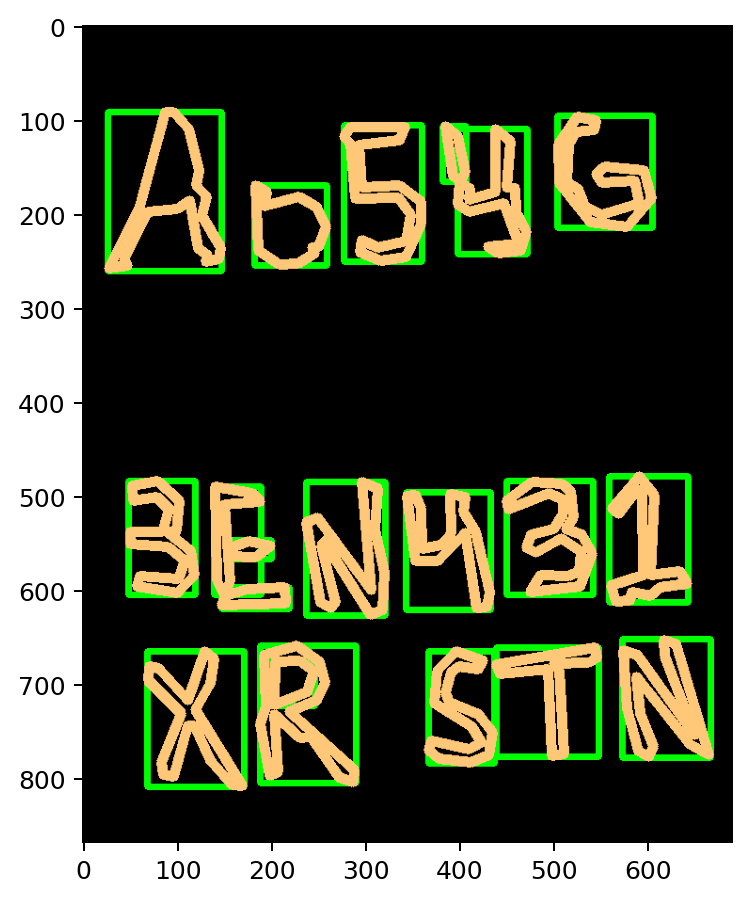

In [45]:
import imutils

canvas = np.zeros(erosion.shape,dtype='uint8')
canvas = cv2.cvtColor(canvas,cv2.COLOR_GRAY2RGB)

#contour finding
keypoints = cv2.findContours(erosion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

#finding character location
char = []
poly = []
prev = [0,0,0,0]
first = 17
for cnt in contours[1:]:
    x,y,w,h = cv2.boundingRect(cnt)
    #checking to see if its not within previous contour
    if not(x>prev[0] and x+w<prev[2]) and not(y>prev[1] and y+h<prev[3]):
        approx = cv2.approxPolyDP(cnt, 5, True)
        if (len(approx) < 100 and len(approx) > 4): #if polygon has more then 4points
            if ((w > 20 or h > 40)): #make sure the width and heght are not too small
                cv2.rectangle(canvas,(x,y),(x+w,y+h),(0,255,0),5)
                rect = cv2.minAreaRect(cnt)
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                
                #filter char one more time and save
                e = cv2.erode(dilation[y:y+h,x:x+w], np.ones((5,5)), iterations=1)
                d = cv2.dilate(e, np.ones((3,3)), iterations=1)
                a = Character(d, [x, y], [w, h])
                char.append(a)
                poly.append(approx)
    prev = [x,y,x+w,y+h]

cv2.drawContours(canvas,poly,-1,(255,200,120),10)

plt.figure(figsize=(8, 6), dpi=180)
plt.imshow(canvas, cmap='gray')

20


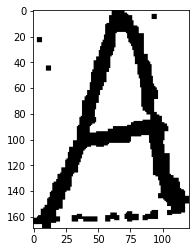

In [46]:
print(len(char))
char[0].printIMG()

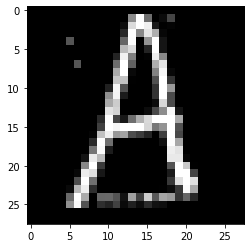

In [47]:
#function to add padding so that image matches dataset
def padding(img, x, y): #new image is 28x28, will be rescaled and padded to match
    (h,w) = img.shape
    a = (x-h)//2
    aa = x-a-h

    b = (y-w)//2
    bb = y-b-w

    return 255-np.pad(255-img, pad_width=((a, aa), (b, bb)), mode='constant')

#pad all characters in char list and invert color to match dataset
for i in range(len(char)):
    img = char[i].getIMG()
    dim = img.shape
    if dim[0]>dim[1]:
        new_dim = tuple((np.flip(np.array(dim))*25/dim[0]).astype('int'))
        
    else:
        new_dim = tuple((np.flip(np.array(dim))*25/dim[1]).astype('int'))
    resized = cv2.resize(img, new_dim, interpolation = cv2.INTER_AREA)
    char[i].setIMG(255-padding(resized,28,28))

char[0].printIMG()

In [48]:
#set up model with the char classifier and structure images to predict
predict = tf.expand_dims(np.array(Character.getIMAGES(char),dtype='float32'),axis=3)
model = tf.keras.models.load_model('Classifiers/charClassifier3.h5')
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [49]:
#predict using model and save in charlist
predictions = model.predict(predict)
predictions = [class_mapping[i] for i in list(np.argmax(predictions,axis=1).astype(int))]
for i in range(len(char)):
    char[i].name(predictions[i])

In [35]:
#sort characters base of y and x positions
pos = Character.getPOS(char)
size = Character.getSIZE(char)
[dx,dy] = Character.getLargestSize(char)
[xend,yend] = np.max(pos,axis=0)
[xstart,ystart] = np.min(pos,axis=0)

text = []
for y in range(ystart,yend+1,dy): #for each line
    idx = np.logical_and(pos[:,1]+size[:,1]/2 < y+dy, pos[:,1]+size[:,1]/2 >= y)
    a = [char[i] for i in range(len(char)) if idx[i]]
    if a!=[]: #order characters by x
        idx = np.argsort(Character.getPOS(a)[:,0],axis=0).astype(int).tolist()
        a = [a[i] for i in idx]
    text.append(a)

In [36]:
Character.printList(text) #show predicted char list as text

AD514G

3FAZ538
X1RD5TW

